In [1]:
# libraries importing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# additional modules
import sys
sys.path.append('../utils')
#from evaluating import evaluating_change_point

## Data loading

In [ ]:
# benchmark files checking
#all_files=[]
#import os
#for root, dirs, files in os.walk("../data/"):
#    for file in files:
#        if file.endswith("times.csv"):
#             all_files.append(os.path.join(root, file))

In [29]:
df = pd.read_csv("out.csv", index_col='time')
df = df.drop(["Unnamed: 0"], axis=1)

## Data description and visualization

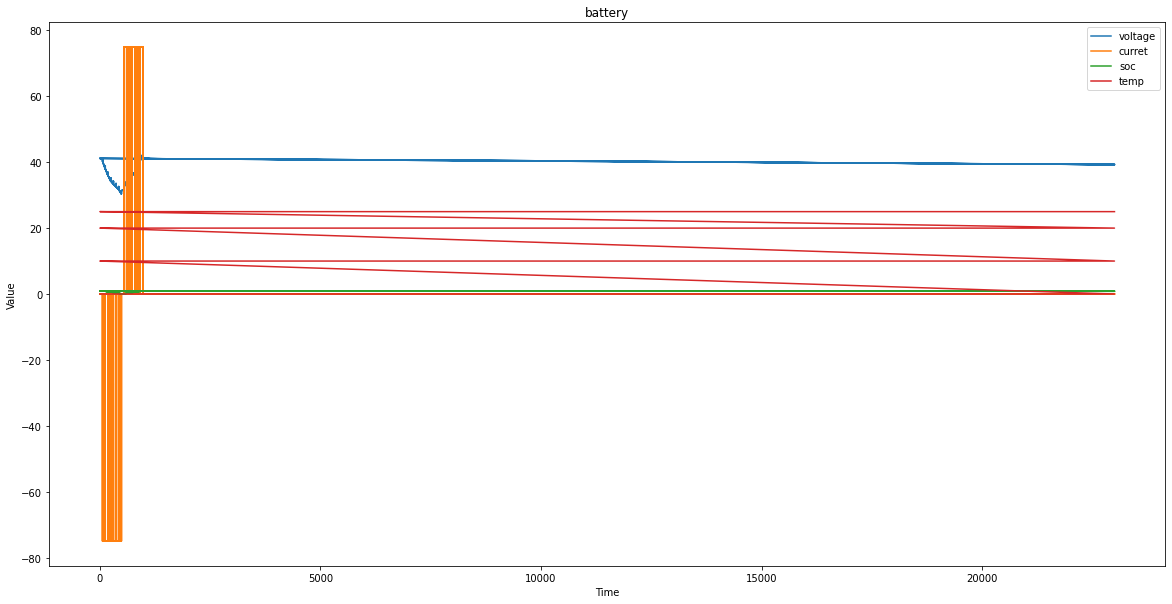

In [42]:
# random dataset visualizing
df.plot(figsize=(20,10))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('battery')
plt.show()

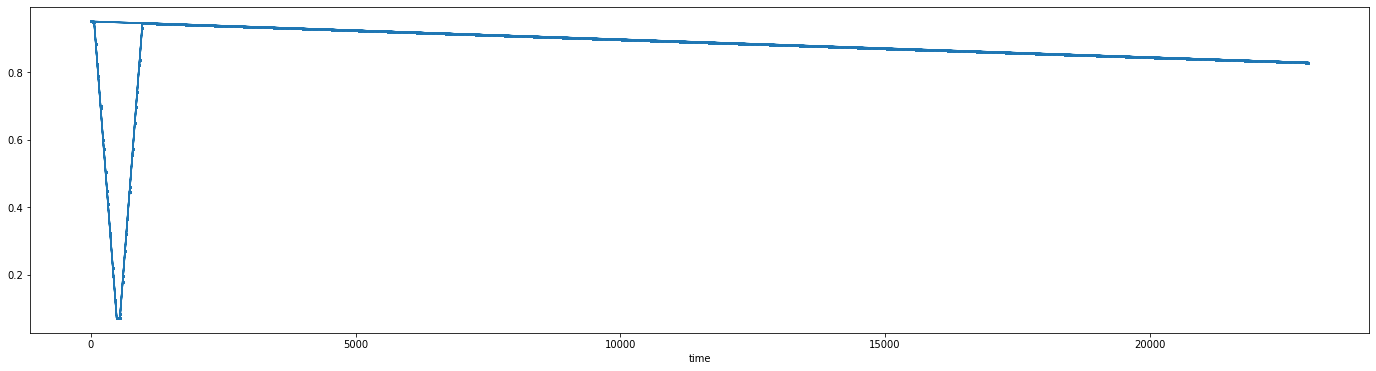

In [41]:
df.soc.plot(figsize=(24, 6), marker='o', markersize=2)

## Labels

## Method applying

In [25]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import medfilt
from sklearn import decomposition
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from itertools import product

In [9]:
# Function for repeatability
def Random(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)

    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)

In [10]:
def arch(data):
    Random(0)
    model = keras.Sequential(
        [
            layers.Input(shape=(data.shape[1], data.shape[2])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    # model.summary()

    history = model.fit(
        data,
        data,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=0)
        ],
    )
    return history, model

### Training in the beginning of each dataset

In [11]:
N_STEPS = 60

In [31]:
# Generated training sequences for use in the model.
def create_sequences(values, time_steps=N_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [35]:
# hyperparameters selection
Q = 0.999 # quantile for upper control limit (UCL) selection

# inference
predicted_outlier, predicted_cp = [], []
Q = 0.999 # quantile for upper control limit (UCL) selection

# inference
predicted_outlier, predicted_cp = [], []
X_train = df[:400]
    
    # scaler init and fitting
StSc = StandardScaler()
StSc.fit(X_train)
    
    # convert into input/output
X = create_sequences(StSc.transform(X_train), N_STEPS)
    
    # model defining and fitting
history, model = arch(X)
    
    # results predicting
residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
UCL = residuals.quantile(Q)
    
    # results predicting
X = create_sequences(StSc.transform(df), N_STEPS)
cnn_residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
    
    # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data = cnn_residuals > (3/2 * UCL)
anomalous_data_indices = []
for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
    if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
    
prediction = pd.Series(data=0, index=df.index)
prediction.iloc[anomalous_data_indices] = 1
    
    # predicted outliers saving
predicted_outlier.append(prediction)
    
    # predicted CPs saving
prediction_cp = abs(prediction.diff())
prediction_cp[0] = prediction[0]
predicted_cp.append(prediction_cp)
X_train = df[:400]
    
    # scaler init and fitting
StSc = StandardScaler()
StSc.fit(X_train)
    
    # convert into input/output
X = create_sequences(StSc.transform(X_train), N_STEPS)
    
    # model defining and fitting
history, model = arch(X)
    
    # results predicting
residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
UCL = residuals.quantile(Q)
    
    # results predicting
X = create_sequences(StSc.transform(df), N_STEPS)
cnn_residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
    
    # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data = cnn_residuals > (3/2 * UCL)
anomalous_data_indices = []
for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
    if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
    
prediction = pd.Series(data=0, index=df.index)
prediction.iloc[anomalous_data_indices] = 1
    
    # predicted outliers saving
predicted_outlier.append(prediction)
    
    # predicted CPs saving

prediction_cp = abs(prediction.diff())
prediction_cp[0] = prediction[0]
predicted_cp.append(prediction_cp)

KeyError: ignored

### Results

In [33]:
predict = predicted_outlier[0]

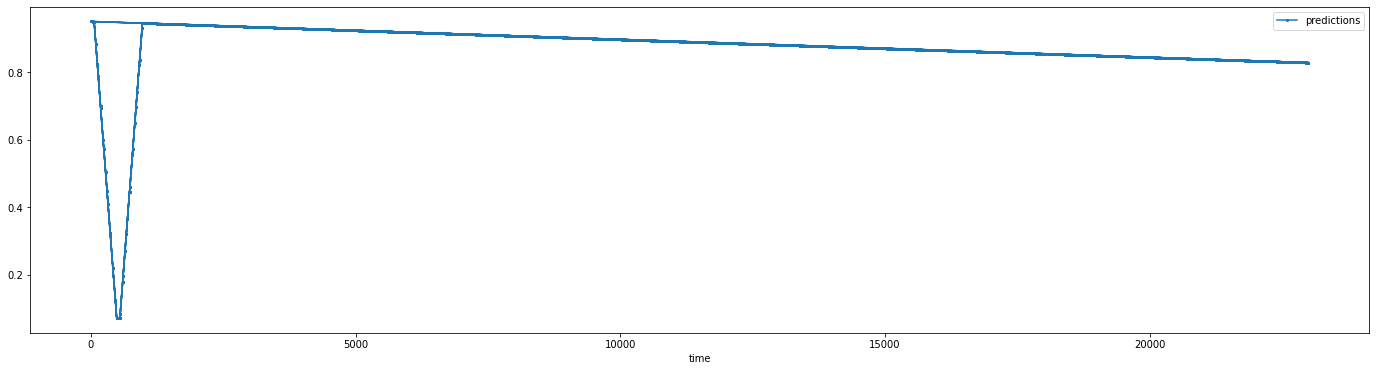

In [36]:
# true outlier indices selection
true_outlier = df.soc

#predict.plot(figsize=(24, 6), label='predictions', marker='o', markersize=5)
true_outlier.plot(figsize=(24, 6), label='predictions', marker='o', markersize=2)

plt.legend();

## Metrics calculation

In [ ]:
# binary classification metrics calculation
binary = evaluating_change_point(true_outlier, predicted_outlier, metric='binary', numenta_time='30 sec')

False Alarm Rate 13.69 %
Missing Alarm Rate 17.77 %
F1 metric 0.79


In [ ]:
# average detection delay metric calculation
add = evaluating_change_point(true_cp, predicted_cp, metric='average_delay', numenta_time='30 sec')

Average delay 0 days 00:00:13.428571428
A number of missed CPs = 116


In [ ]:
# nab metric calculation
nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')

Intersection of the windows of too wide widths for dataset 16
Intersection of the windows of too wide widths for dataset 16
Intersection of the windows of too wide widths for dataset 16
Intersection of the windows of too wide widths for dataset 18
Intersection of the windows of too wide widths for dataset 18
Intersection of the windows of too wide widths for dataset 18
Intersection of the windows of too wide widths for dataset 19
Intersection of the windows of too wide widths for dataset 19
Intersection of the windows of too wide widths for dataset 19
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 27
Intersec